# 细胞图像分割Report - 邓忠寒
**目标**:设计细胞图像分割模型，并在测试数据上生成细胞分割结果 <br>

**存在问题**:给定的training data过少。在网上搜索大量资料，企图寻找相关的细胞图像数据，最终在Kaggle上找到[2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018/data?select=stage1_train_labels.csv.zip)，是我找到唯一一个十分接近目标图像的数据库，但是也仅有600多个training 数据。

## 1. 什么是图像分割(Image Segmentation)？
一个图片是由pixels组成，image segmentation是将一个图片分成多个segments的过程。分割的目标是去简单化或者说是改变一个图片的representaion，让它的representation更有意义，也更容易被分析。Image segmentation被用于定位objects。更准确点说，image segementation是把每一个pixel都assign一个label的过程，具有相同label的pixel共享这某一些特性。<br>
来源：https://en.wikipedia.org/wiki/Image_segmentation


## 2. 图像分割的种类
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/Screenshot-from-2019-03-28-12-08-09.png)
<br>
图片来源：https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/Screenshot-from-2019-03-28-12-08-09.png

实际上我们可以大致的将图片分割化为两大类。<br>

- semantic segmentation: 如图所示，每一个pixel属于一个特定的class(要么是背景要么是人)。并且，所有来自同一个class的被标示为同一个颜色(背景为黑色，人为粉色)。
- inseance segmentation: 如图所示，在同一个class里面的不同的object(人)也被标示成了不同的颜色。

综上所示，semantic segmentation目标是classify所有的人作为一个instance，然而instance segmentation目标是把每一个人单独分开。在当前的report中，我们的目标是semantic segmentation。

来源：https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/

## 3. 图像分割与物体检测(Object Detection)的区别
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/instance_segmentation_example.jpg) <br>
图片来源：cs231n.stanford.edu

在一个图片中，object detection是在对每一个class建立一个边界框。它告诉了我们物体所在的大概位置(也就是边框的坐标)，但是我们无法得知目标的具体形状。<br>
在一个图片中，image segmentation创造一个在pixel-wise的mask给每一个物体，这个技术给予我们更加细化的理解。在医学界，如果我们能很早的检测出病人的癌症，将大大提高其存活率，然而癌症细胞的一个重要的特点，就是它的形状会给予癌症严重性的重要信息。

## 4. 数据的预处理

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from zipfile import ZipFile 
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras

In [2]:
# set up hyperparameter
img_height = 256
img_width = 256
img_channel = 3

In [3]:
def unzip(keyword = None):
    """
    input: train / test
    objective: unzip file
    """
    file_name = f"../input/data-science-bowl-2018/stage1_{keyword}.zip"
    with ZipFile(file_name, 'r') as zip: 
        print(f'{keyword} file unzipping')
        zip.extractall(f"stage1_{keyword}") 
        print('Done!')

In [4]:
unzip('train') # unzip train
unzip('test') # unzip test

train file unzipping
Done!
test file unzipping
Done!


In [5]:
# set up train and test path
train_path = "stage1_train/"
test_path = "stage1_test/"

In [6]:
# save all the training ids
train_ids = os.listdir(train_path)
print(f'There are {len(train_ids)} training samples.')

There are 670 training samples.


In [7]:
def preprocess(id_, path):
    """
    input: list of ids, path of directory
    output: return X_train and y_train
    """
    
    # initialize two empty array to store
    # size is (# of training instance, img_size, img_size, img_channel)
    X_train = np.zeros((len(id_), img_height, img_width, img_channel), dtype = np.uint8)
    Y_train = np.zeros((len(id_), img_height, img_width, 1), dtype = np.bool)
    
    # iterate through all the training img, save each training instance into X_train
    # using tqdm is good for us to visualize the process
    for n, id_ in tqdm(enumerate(id_), total = len(id_)):   
        cur_path = path + id_
        # read in img as array
        img = imread(cur_path + '/images/' + id_ + '.png')[:,:,:img_channel]  
        # resize data to increase the speed of training
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        # save current img into X_train
        X_train[n] = img  
        # for each img, we have several masks
        # we need to iterate through each one 
        mask = np.zeros((img_height, img_width, 1), dtype = np.bool)
        for mask_file in os.listdir(cur_path + '/masks/'):
            # read in current mask
            cur_mask = imread(cur_path + '/masks/' + mask_file)
            # resize it and adjust the dimension to 128x128x1
            cur_mask = np.expand_dims(resize(cur_mask, (img_height, img_width), mode = 'constant', preserve_range = True), axis = -1)
            mask = np.maximum(mask, cur_mask)
        Y_train[n] = mask
    return X_train, Y_train

In [8]:
X_train, y_train = preprocess(train_ids, train_path)

100%|██████████| 670/670 [03:23<00:00,  3.29it/s]


模型启发: 因为我们在做的事细胞分割，所以在经过一定的research之后，发现U-Net模型框架比较适合。<br>
模型介绍: U-Net是一款为生物医学图像分割创造出的模型，最开始被Freiburg大学的电脑科学院所开发。<br>
模型框架: <br>

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

我们可以看到这个框架一共有9个部分，我们可以大致给他分成encoder和decoder两部分。<br>

- 前面的5个部分通常被视为encoder部分均由两个3x3的conv layer接上一个2x2的max pooling。<br>
- 后面的4个部分通常被视为decoder阶段，由一个conv Transposelayer + concat + 两个3x3conv layer。<br>
- 在decoder阶段，U-Net框架会拼接之前decoder阶段的部分，对其进行卷积。<br>

U-Net优点是在较少的training samples仍然能有比较理想的结果，这打破了传统深度学习框架通常需要数以千计或者万计training samples的弊端。这也正符合我们的需要因为我们仅有670training samples。<br>

Loss Function and Metric <br>
- 在做binary classification的时候，binary cross-entropy是一个非常常用的loss function，它度量错误classification的概率。 <br>
- 另外一个在image segmentation中比较常用的叫做dice coefficient，它的就算是2乘以两个图片overlap的面积再除以所有的面积。这个metric的区间在0到1之间。1代表完美的overlap。<br>

我们会采用binary cross-entropy作为loss function，采用accuracy和dice coefficient作为metric。

## 5. 模型建造

In [53]:
smooth = 1.
# define dice coefficient metric
def dice_coef(y_true, y_pred):
    # flatten
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # find intersection
    intersection = K.sum(y_true_f * y_pred_f)
    # 2 * intersection / overall
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [54]:
inputs = tf.keras.layers.Input((img_height, img_width, img_channel))
# Normalize the data
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Encode
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(c5)

# Decode 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(u6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(u7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(u8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(u9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(c9)

# outpput
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

# compile
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', dice_coef]) 

In [55]:
callbacks = [EarlyStopping(patience = 5, monitor = 'val_loss'), ModelCheckpoint('U-Net-Best.h5', verbose=1, save_best_only = True)]

## 6. 模型训练

In [56]:
results = model.fit(X_train, y_train, validation_split = 0.1, batch_size = 16, epochs = 30, callbacks = callbacks) 

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.8429 - dice_coef: 0.2137
Epoch 00001: val_loss improved from inf to 0.36499, saving model to U-Net-Best.h5
38/38 [==============================] - 3s 89ms/step - loss: 0.5551 - accuracy: 0.8429 - dice_coef: 0.2137 - val_loss: 0.3650 - val_accuracy: 0.8572 - val_dice_coef: 0.2673
Epoch 2/30
38/38 [==============================] - ETA: 0s - loss: 0.2893 - accuracy: 0.8623 - dice_coef: 0.3789
Epoch 00002: val_loss improved from 0.36499 to 0.25355, saving model to U-Net-Best.h5
38/38 [==============================] - 3s 74ms/step - loss: 0.2893 - accuracy: 0.8623 - dice_coef: 0.3789 - val_loss: 0.2536 - val_accuracy: 0.8730 - val_dice_coef: 0.4373
Epoch 3/30
37/38 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9200 - dice_coef: 0.6130
Epoch 00003: val_loss improved from 0.25355 to 0.16986, saving model to U-Net-Best.h5
38/38 [==============================] - 3s 72ms/step - 

In [57]:
def generate_plot(history, keyword = ''):
    plt.plot(history.history[keyword])
    plt.plot(history.history[f'val_{keyword}'])
    plt.title(f'model {keyword}')
    plt.ylabel(f'{keyword}')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc = 'upper left')
    plt.show()

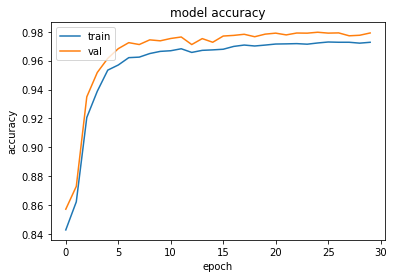

In [58]:
generate_plot(results, 'accuracy')

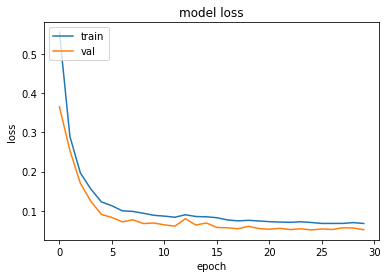

In [59]:
generate_plot(results, 'loss')

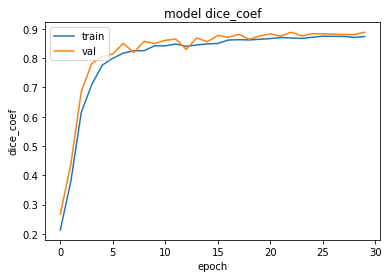

In [60]:
generate_plot(results, 'dice_coef')

## 7. 模型结果分析
我们可以看到经过几个epoch我们就达到了一个十分可观的回报，我们最好的model的val_loss在0.5左右，val accuracy在0.97左右，val dice coefficient在0.88左右。这个结果还是比较理想的，因为我们的test sample的取样不同于train sample，所以我们也不想把模型过度训练，这样不利于模型generalize。所以我们在callback中设定了earlystopping以防止overfitting。我们将patience设定为5，已经给了model足够的时间。从accuracy和loss还有codice coefficient的图可以看我们的model在validation set的表现是略好于training set。这是我们通常想要的，这可以在一定程度上体现模型的generalize的能力。当然valiadation set还不能完全当作test set，毕竟我们是通过给model看到validation set进行调试的，而test set通常是model完全看不到的。综上所述我们得到了我认为还算不错的结果。接下来我们运用训练好的模型对training data进行呈现。

In [61]:
# load best model
model = keras.models.load_model('U-Net-Best.h5', custom_objects = {'dice_coef': dice_coef})
# make prediction on X_train
preds_train = model.predict(X_train, verbose = 1)
# set threshold as 0.5
preds_train_t = (preds_train > 0.5).astype(np.uint8)

21/21 [==============================] - 1s 41ms/step


## 8. 模型在training data预测

In [62]:
def show_pred():
    """
    Random generate id, show X_train, y_train and prediction
    """
    index = random.randint(0, len(preds_train_t))
    imshow(X_train[index])
    plt.title('X_train')
    plt.show()
    imshow(np.squeeze(y_train[index]))
    plt.title('y_train')
    plt.show()
    imshow(np.squeeze(preds_train_t[index]))
    plt.title('Prediction')
    plt.show()

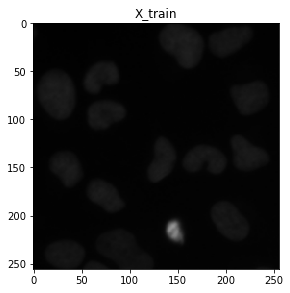

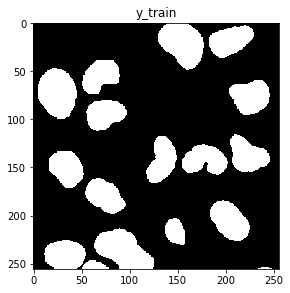

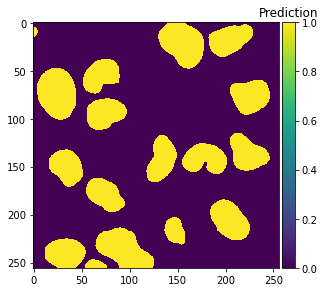

In [63]:
show_pred()

## 9. 模型在test img上预测

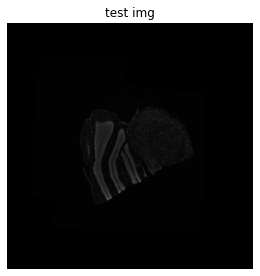

In [64]:
# import our test img and reshape the array size
test = imread('../input/test111/newtest.png')
test_reshape = test.reshape(1, 256, 256, 3)
imshow(np.squeeze(test_reshape))
plt.title('test img')
plt.axis('off')
plt.show()

In [38]:
# make prediction
pred = model.predict(test_reshape)
pred_t = (pred > 0.5).astype(np.uint8)

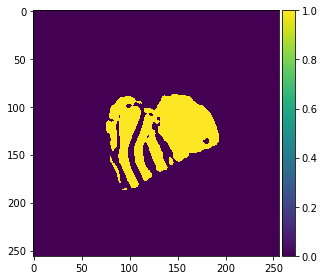

In [39]:
imshow(np.squeeze(pred_t[0]))
plt.show()

## 9. 模型的未来以及改进
即使U-Net已经表现的很好，但是它仍然有一些缺陷。它依赖于多层级联卷积神经网络，这些级联的网络提取感兴趣的部分进行密集预测，这导致了过度和冗余使用计算资源，因为它重复提取低级特征。<br>
future work的一个方向是集中在对于attention-Unet的研究。attention在图像分割中是一个在training中highlight only relevent的方式。它大大的减少了计算资源的浪费，给予network更强大的power。[来源](https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831#:~:text=Attention%2C%20in%20the%20context%20of,network%20with%20better%20generalisation%20power.)<br>
另一个方向是对于Unet++的研究。Unet++志在通过在encoder和decoder之间加入dense block和conv layers提高分割准确率。[论文链接](https://arxiv.org/abs/1807.10165)